# 102 category flower classification using ResNet50

## 1. Import Necessary Libraries

In [1]:
import os
from pathlib import Path
import scipy

## 2. Define Data Paths
We set paths to the data directory and metadata files (label and split files).

In [2]:
# Set path to data directory
data_dir = Path("/kaggle/input/102-flowers")

# Set path to label files & split files
label_file = data_dir / "imagelabels.mat"
split_file = data_dir / "setid.mat" 

## 3. Load Dataset Metadata
We'll load the `.mat` files containig the labels and train/test splits using `scipy.io.loadmat()`.

In [3]:
labels_data = scipy.io.loadmat(label_file)
splits_data = scipy.io.loadmat(split_file)

labels_data, splits_data

({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
  '__version__': '1.0',
  '__globals__': [],
  'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
  '__version__': '1.0',
  '__globals__': [],
  'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
  'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
  'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)})

## 4. Extract label and split indices
We'll extract the 102 labels of the flower and the indices of the images which define which images belong to which split (train/test).

In [4]:
labels = labels_data['labels'].flatten()
train_indices = splits_data['trnid'].flatten()
test_indices = splits_data['tstid'].flatten()
val_indices = splits_data['valid'].flatten()

print(f'First five labels: {labels[:5]}')
print(f'Min value of train_indices: {train_indices.min()}')
print(f'Min value of test_indices: {test_indices.min()}')
print(f'Min value of val_indices: {val_indices.min()}')
print()
print(f'Length of train_indices: {len(train_indices)}')
print(f'Length of test_indices: {len(test_indices)}')
print(f'Length of val_indices: {len(val_indices)}')

First five labels: [77 77 77 77 77]
Min value of train_indices: 28
Min value of test_indices: 1
Min value of val_indices: 17

Length of train_indices: 1020
Length of test_indices: 6149
Length of val_indices: 1020


## 5. Map indices to Image Path

In [5]:
# Load and sort all the image files
data_path = data_dir / "images/images"
images_files = sorted(list(data_path.glob("*.jpg")))

images_files[:5]

[PosixPath('/kaggle/input/102-flowers/images/images/image_00001.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00002.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00003.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00004.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00005.jpg')]

In [6]:
# Create lists of image paths and corresponding labels for the training set.
# i-1 adjustment is done for matching the indices from matlab to python's zero based system
train_images = [images_files[i-1] for i in train_indices]  
train_labels = [labels[i-1] for i in train_indices]

test_images = [images_files[i-1] for i in test_indices]
test_labels = [labels[i-1] for i in test_indices]


val_images = [images_files[i-1] for i in val_indices]
val_labels = [labels[i-1] for i in val_indices]

# Checking the data
print(f'Min train_images value: {min(train_images)}')
print(f'Min test_values: {min(test_images)}')
print(f'Min val_values: {min(val_images)}')
print()
print(f'Length of train_images: {len(train_images)}')
print(f'Length of test_images {len(test_images)}')
print(f'Length of val_images: {len(val_images)}')

Min train_images value: /kaggle/input/102-flowers/images/images/image_00028.jpg
Min test_values: /kaggle/input/102-flowers/images/images/image_00001.jpg
Min val_values: /kaggle/input/102-flowers/images/images/image_00017.jpg

Length of train_images: 1020
Length of test_images 6149
Length of val_images: 1020


## 6. Define Transformations
We use the standard preprocessing transformations for ResNet50, including resizing, cropping, and normalization.

In [7]:
import torch
from torchvision import transforms
from torchvision import models

# Load pretrained weights for ResNet50
pretrained_weights = models.ResNet50_Weights.DEFAULT

# Define the common transforms for input data
common_transforms = pretrained_weights.transforms()
common_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
# Define train and test transformations

train_transform = transforms.Compose([
    transforms.Resize(common_transforms.resize_size),  # Resize to 232
    transforms.RandomCrop(common_transforms.crop_size, padding=4),  # Mild crop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),  
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),  # Milder color changes
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=common_transforms.mean, std=common_transforms.std)
])

val_test_transform = transforms.Compose([
    transforms.Resize([232]),
    transforms.CenterCrop([224]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print(train_transform)
print(val_test_transform)

Compose(
    Resize(size=[232], interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.3)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.05, 0.05))
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=[232], interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## 7. Create custom Dataset Class

This class defines a custom dataset for PyTorch, inheriting from `torch.utils.data.Dataset`. It is designed to handle various data formats (e.g., images, features, etc.) and their corresponding labels. 

#### Key Components:
1. **`__init__(self, data, labels, transform=None)`**:
   - Initializes the dataset with input data, labels, and an optional transform function.
2. **`__len__(self)`**:
   - Returns the total number of samples in the dataset.
3. **`__getitem__(self, idx)`**:
   - Retrieves a specific data sample and its corresponding label by index.
   - Optionally applies a transform to the data sample.

In [9]:
# Change the device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
from torch.utils.data import Dataset
from PIL import Image
from collections import Counter

class CustomDataset(Dataset):
    def __init__(self, data_path, labels, transform=None):  # Make transform optional
        self.data_path = data_path
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, idx: int):
        img = Image.open(self.data_path[idx]) 
        img.convert('RGB')

        if self.transform:
            img = self.transform(img)  # Apply transformation only if provided

        label = self.labels[idx] - 1  # Assuming labels are 1-indexed
        return img, label
        
    def __len__(self):
        return len(self.data_path)

def compute_class_weights(labels, num_classes=102):
    """Compute class weights for imbalanced dataset"""
    label_counts = Counter(labels)
    total = len(labels)
    weights = torch.zeros(num_classes)
    
    for i in range(num_classes):
        count = label_counts.get(i + 1, 1)  # +1 because labels are 1-indexed
        weights[i] = total / (num_classes * count)
    
    return weights

train_dataset = CustomDataset(train_images, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_images, val_labels, transform=val_test_transform)
test_dataset = CustomDataset(test_images, test_labels, val_test_transform)

# Compute class weights
class_weights = compute_class_weights(train_labels).to(device)

print(f'Length of train_dataset: {len(train_dataset)}')
print(f'Length of test_dataset {len(test_dataset)}')
print(f'Length of val_dataset: {len(val_dataset)}')

Length of train_dataset: 1020
Length of test_dataset 6149
Length of val_dataset: 1020


### Visualize the data

In [11]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import copy

# function to plot transformerd images
def plot_transformed_images(image_paths, labels, transform, n=3, seed=None):
    # Use the seed if mentioned
    if seed:
        random.seed(seed)

    # Create a tuple of image paths and the respective labels of the images
    data = list(zip(image_paths, labels))

    # Select random images
    random_image_paths = random.sample(data, k=n)
    for image in random_image_paths: # iterate through each image 
        img, y = image               # unpack the image and label
        with Image.open(img) as f:
            # Create a subplot of 2 images one for original and other for transformed image 
            fig, ax = plt.subplots(1, 2)

            # Visualize the original Image
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Visualize the transformed image
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            # Mention the respective class of the image
            fig.suptitle(f"Class: {y}", fontsize=16)

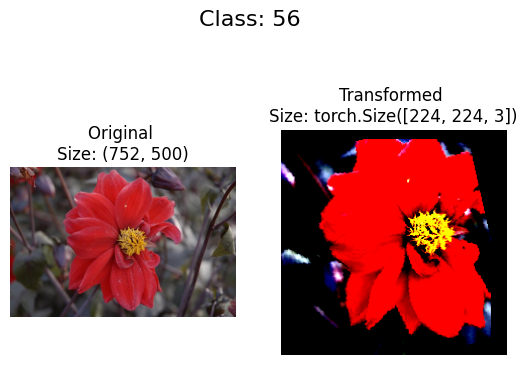

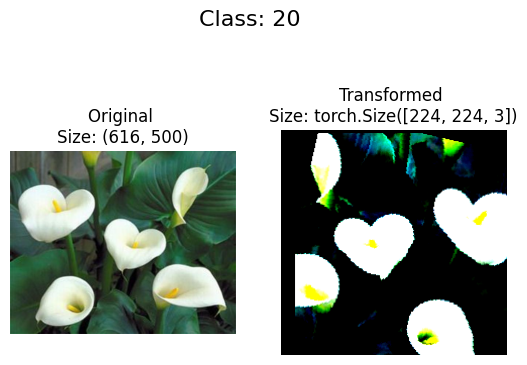

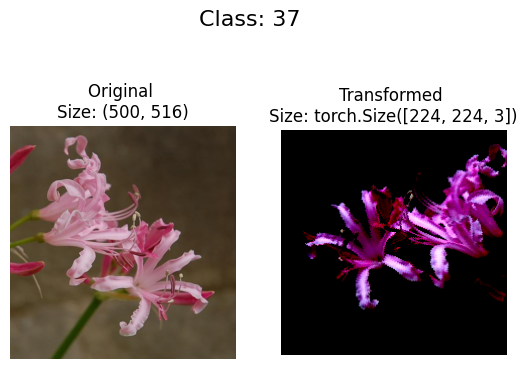

In [12]:
# Plot the original vs transformed image
plot_transformed_images(train_images, train_labels, transform=train_transform, n=3)

## 8. Model with Dropout

In [13]:
import torch
import torch.nn as nn
from torchvision import models

def create_model_with_dropout(dropout=0.5):
    """
    Create ResNet50 with dropout before final layer.
    """
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    
    # Replace final layer with dropout + linear
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_features, 102)
    )
    
    return model

## Metrics

In [14]:

from torchmetrics import Accuracy
from torchmetrics.functional import accuracy, precision, recall, f1_score

def compute_metrics(preds, targets):
    """Compute comprehensive metrics"""
    acc = accuracy(preds, targets, task='multiclass', num_classes=102, average='micro')
    prec = precision(preds, targets, task='multiclass', num_classes=102, average='macro')
    rec = recall(preds, targets, task='multiclass', num_classes=102, average='macro')
    f1 = f1_score(preds, targets, task='multiclass', num_classes=102, average='macro')
    return {
        'accuracy': acc.item(),
        'precision': prec.item(),
        'recall': rec.item(),
        'f1': f1.item()
    }



## 9. Training Functions

In [15]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    all_preds, all_targets = [], []
    
    for X, y in dataloader:
        X, y = X.to(device), y.long().to(device)
        
        # Forward pass
        y_hat = model(X)
        loss = criterion(y_hat, y)
        train_loss += loss.item()
        
        # Collect predictions
        preds = torch.argmax(y_hat, dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute metrics
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    metrics = compute_metrics(all_preds, all_targets)
    
    return train_loss / len(dataloader), metrics


def validate(model, dataloader, criterion, device):
    """Validation with comprehensive metrics"""
    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.long().to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            val_loss += loss.item()
            
            preds = torch.argmax(y_hat, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    metrics = compute_metrics(all_preds, all_targets)
    
    return val_loss / len(dataloader), metrics



## 10. Hyperparameter Tuning 

### Optuna Objective

In [16]:
import torch.nn as nn 
import torch.optim as optim 
import optuna 
from optuna.exceptions import TrialPruned
from torch.utils.data import DataLoader
from torchvision import models 
from tqdm.auto import tqdm

def objective(trial):
    """Optuna objective"""
    
    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.4, 0.6)
    
    # Create dataloaders
    train_loader_opt = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader_opt = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
    
    # Create model with dropout
    model = create_model_with_dropout(dropout=dropout)
    model = model.to(device)
    
    # Loss with class weights (helps with imbalance)
    # If you computed class_weights, use: criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()  # Use this if no class_weights
    
    # Optimizer
    if optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # StepLR scheduler as you prefer
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Training loop
    best_f1 = 0.0
    patience_counter = 0
    PATIENCE = 4
    
    for epoch in range(20):
        train_loss, train_metrics = train_epoch(
            model, train_loader_opt, optimizer, criterion, device
        )
        
        val_loss, val_metrics = validate(model, val_loader_opt, criterion, device)
        
        # Report to Optuna
        trial.report(val_metrics['f1'], epoch)
        
        # Check if trial should be pruned
        if trial.should_prune():
            raise TrialPruned()
        
        # Early stopping
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= PATIENCE:
            break
        
        scheduler.step()
    
    return best_f1

### Run study 

In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 30) 

print("Best trial:") 
print("F1 Score:", study.best_trial.value) 
print(" Params:") 
for key, value in study.best_trial.params.items(): 
    print(f" {key}: {value}")

[I 2025-11-21 15:09:25,415] A new study created in memory with name: no-name-0a5f006d-4010-4c4e-9c5e-d5f91e0f5191
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]
[I 2025-11-21 15:11:04,113] Trial 0 finished with value: 0.006038888357579708 and parameters: {'lr': 0.003250642776958015, 'optimizer': 'Adam', 'batch_size': 16, 'weight_decay': 0.000333250896839892, 'dropout': 0.43741688110847393}. Best is trial 0 with value: 0.006038888357579708.
[I 2025-11-21 15:14:49,468] Trial 1 finished with value: 0.9276527762413025 and parameters: {'lr': 0.0002957440816676501, 'optimizer': 'AdamW', 'batch_size': 32, 'weight_decay': 0.00036981117056023624, 'dropout': 0.5594906038243758}. Best is trial 1 with value: 0.9276527762413025.
[I 2025-11-21 15:17:58,532] Trial 2 finished with value: 0.9003720283508301 and parameters: {'lr': 0.00010016417817198575, 'optimizer': 

Best trial:
F1 Score: 0.9433236718177795
 Params:
 lr: 0.00022715809721755387
 optimizer: Adam
 batch_size: 16
 weight_decay: 1.065704022543824e-05
 dropout: 0.4664370979686941


## 11. Create Dataloaders

We create the `train_loader`, `val_loader`, `test_loader` with mini-batch size of 32.
* `train_loader` feeds batches of training data to the model during training.
* `val_loader` is used during training to monitor performance on unseen data and detect overfitting.
* `test_loader` is used after training to evaluate final model performance on a separate test set.
 
The reason of using `shuffle=True` for `train_loader` and `shuffle=False` (default) for `val_loader` and `test_loader`:
* Shuffling is used to break the sequential order of data, helping to improve model generalization and avoid overfitting to data patterns.
* Validation and testing datasets do not require shuffling since they are only used to evaluate the model's performance.

In [19]:
from torch.utils.data import DataLoader

best_params = study.best_trial.params

# Get the best batch size 
batch_size = best_params.get('batch_size', 32)

# Create the DataLoader for the training dataset
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True)    # Randomly shuffle the data at the start of each epoch to improve model generalization

# Create the DataLoader for the validatoin dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # No shuffling needed for validation, as order doesn't affect model evaluation

# Create the DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size) 

## 12. Training Functions

In [20]:

def train_final_model(train_loader, val_loader, best_params):
    """
    Train final model with best hyperparameters.
    """
    
    # Create model with best dropout
    model = create_model_with_dropout(dropout=best_params.get('dropout', 0.5))
    model = model.to(device)
    
    # Loss with class weights
    # criterion = nn.CrossEntropyLoss(weight=class_weights)  # If you have class_weights
    criterion = nn.CrossEntropyLoss()  # Otherwise use this
    
    # Optimizer with best params
    lr = best_params.get('lr', 0.001)
    weight_decay = best_params.get('weight_decay', 1e-4)
    
    if best_params.get('optimizer') == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # StepLR scheduler (as you prefer)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    
    # Training loop
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    patience_counter = 0
    PATIENCE = 7
    
    print("Starting final training...")
    
    for epoch in tqdm(range(50)):
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, criterion, device
        )
        
        val_loss, val_metrics = validate(model, val_loader, criterion, device)
        
        print(
            f"Epoch {epoch:2d} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_metrics['accuracy']:.4f} | Train F1: {train_metrics['f1']:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_metrics['accuracy']:.4f} | Val F1: {val_metrics['f1']:.4f}"
        )
        
        # Early stopping
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print("New best model!")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break
        
        scheduler.step()
    
    # Load best weights
    model.load_state_dict(best_model_wts)
    print(f"\n Best F1 Score: {best_f1:.4f}")
    
    return model

## 13. Train Final Model with best parameters

In [21]:

final_model = train_final_model(train_loader, val_loader, best_params)

Starting final training...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch  0 | Train Loss: 4.4453 | Train Acc: 0.0725 | Train F1: 0.0629 | Val Loss: 3.5418 | Val Acc: 0.4363 | Val F1: 0.3879
New best model!
Epoch  1 | Train Loss: 2.6203 | Train Acc: 0.4716 | Train F1: 0.4410 | Val Loss: 1.2693 | Val Acc: 0.7206 | Val F1: 0.7009
New best model!
Epoch  2 | Train Loss: 1.1642 | Train Acc: 0.7520 | Train F1: 0.7450 | Val Loss: 0.7411 | Val Acc: 0.8108 | Val F1: 0.8074
New best model!
Epoch  3 | Train Loss: 0.6590 | Train Acc: 0.8422 | Train F1: 0.8401 | Val Loss: 0.5271 | Val Acc: 0.8696 | Val F1: 0.8681
New best model!
Epoch  4 | Train Loss: 0.3906 | Train Acc: 0.9206 | Train F1: 0.9199 | Val Loss: 0.5208 | Val Acc: 0.8657 | Val F1: 0.8651
No improvement for 1 epochs
Epoch  5 | Train Loss: 0.3017 | Train Acc: 0.9314 | Train F1: 0.9310 | Val Loss: 0.4564 | Val Acc: 0.8882 | Val F1: 0.8878
New best model!
Epoch  6 | Train Loss: 0.1975 | Train Acc: 0.9549 | Train F1: 0.9551 | Val Loss: 0.4104 | Val Acc: 0.9020 | Val F1: 0.8991
New best model!
Epoch  7 | Trai

## 14. Evaluate on Test Data

In [22]:

test_loss, test_metrics = validate(final_model, test_loader, nn.CrossEntropyLoss(), device)
print("\n Final Test Results:")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test F1 Score: {test_metrics['f1']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")



 Final Test Results:
Test Accuracy: 0.9140
Test F1 Score: 0.9104
Test Precision: 0.9034
Test Recall: 0.9297


## 15. Save the Model

In [23]:

torch.save(final_model.state_dict(), 'best_flower_model.pth')
print("Model saved!")


Model saved!


## 16 Saving Model to ONXX format

In [24]:
import torch
import torch.onnx

# Dummy input for ONNX tracing (adjust shape to your input)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
torch.onnx.export(
    final_model,                              
    dummy_input,                        # dummy input
    "resnet50_flower.onnx",             # output filename
    export_params=True,                 # store the trained weights
    opset_version=11,                   # ONNX version
    do_constant_folding=True,           # optimize constant operations
    input_names = ['input'],            # input layer name
    output_names = ['output'],          # output layer name
    dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}  # allow variable batch size
)

print("Model exported to ONNX format: resnet50_flower.onnx")

Model exported to ONNX format: resnet50_flower.onnx
